# Topic Modeling with BERT

We saw that previous topic modeling attempts using TF-IDF and LDA were promising but far from perfect owing to several factors:
- LDA does not take into account contextual information as it uses 'bag of words'
- Hyperparameter tuning was an involved process with subjective tweaking
- It was difficult to end up with meaningful topics 
- All of the documents were forced into topics


While looking through the web for some solutions, I came across this [blog post](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6) by Maarten Grootendorst where he goes through the step by step process of Topic Modeling with BERT. This looked like the exact work flow I needed for my Topic Modeling problem.


BERT (Bidirectional Encoder Representations from Transformers) is a state of the art language model for NLP in that it is a bidirectionally trained Transformer. This allows for a language model with a deeper sense of language context and flow compared to single-direction language models. It can also incorporate pre-trained models, which can be helpful as they should contain more accurate representation of words and sentences. 


The work flow is as follows:

1. Prepare the data
2. Generate BERT embeddings
3. Reduce dimensionality with UMAP
4. Cluster using HDBSCAN
5. Create Topics based on TF-IDF scores of a cluster
6. Reduce Topics by merging similar ones

I will go through this step by step and finally use Maarten's fantastic BERTopic package to do the same thing in a few lines of code and create an interactive visualization. 

To make things a quicker I am using Google Colaboratoy and making use of the GPU in this notebook.

In [ ]:
! pip install bertopic[all]

     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 6.4MB 23.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 13.2MB 227kB/s 
     |████████████████████████████████| 81kB 10.0MB/s 
     |████████████████████████████████| 92kB 11.5MB/s 
  Using cached https://files.pythonhosted.org/packages/3f/03/c3526fb4e79a793498829ca570f2f868204ad9a8040afcd72d82a8f121db/numpy-1.21.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
     |████████████████████████████████| 4.3MB 42.3MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 450kB 45.6MB/s 
     |████████████████████████████████| 1.3MB 37.6MB/s 
     |████████████████████████████████| 6.4MB 13.8MB/s 
     |████████████████████████████████| 1.1MB 42.0MB/s 
     |████████████████████████████████| 1.2MB 33.6MB/s 
     |███████

In [ ]:
# Set up GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# Connect to G-drive
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Data preparation

For sentence transformers like BERT, we want to keep the original format of the texts as much as possible as it helps to contextualize the contents of the document. So this is my strategy for data preparation: 

Text data about the publication:
- `title` 
- `publication_type` 
- `abstract`
- `journal_title` 
- `affiliations`

Preprocessing data for topic analysis:
- `title` : remove ' - PubMed'
- `publication_type` : impute 'Uncategorized' into null
- `abstract` : impute ''
- `journal_title` 
- `affiliations` : create one long string of all affiliations, take out email address.
- `pub_year` : get from `citation`

I want to format the text data in the following way:


*"`title` \n*
 
 
 *\n*
 
 
 *Published in `pub_year` in `journal_title` as `pub_type`. In affiliation with `affiliations`. \n*
 
 
 *\n*
 
 
 *`abstract`"*

In [ ]:
# Read in dataframe
df = pd.read_csv('/content/gdrive/MyDrive/BS - Data Science Bootcamp/Capstone/pubmedscrape_full.csv', index_col=0)
df.head()

,article_id,title,publication_type,abstract,journal_title,citation,n_authors,affiliations,n_affiliations,n_citations,keywords,n_references
0,31662153,Stem cell therapy for neurological disorders -...,Review,\n\n \n Neurological disease encompa...,South African medical journal = Suid-Afrikaans...,2019 Sep 10;109(8b):70-77.,4,"['Department of Pathology and Immunology, Facu...",1,5,"['Cell', 'Humans', 'Nervous System Diseases / ...",NaN
1,30053745,Neural stem cell therapy-Brief review - PubMed,Review,\n\n \n Adult mammalian neural stem ...,Clinical neurology and neurosurgery,2018 Oct;173:8-14.,3,"['Department of Anatomy, Medical University of...",3,13,"['Animals', 'Cell Differentiation / physiology...",NaN
2,30121644,Stem Cell Therapy in Heart Diseases - Cell Typ...,Review,\n\n \n A large number of clinical t...,Cellular physiology and biochemistry : interna...,2018;48(6):2607-2655.,3,['Reference and Translation Center for Cardiac...,6,35,"['Embryonic Stem Cells / cytology', 'Embryonic...",NaN
3,28543595,Stem Cell Therapy: A New Therapeutic Option fo...,Review,\n\n \n Cardiovascular diseases are ...,Journal of cellular biochemistry,2018 Jan;119(1):95-104.,7,"['Department of Medical Biotechnology, School ...",7,27,"['Cardiovascular Diseases / etiology', 'Cardio...",NaN
4,30039439,Stem Cell Therapy for Multiple Sclerosis - PubMed,Review,\n\n \n Multiple sclerosis (MS) is a...,Advances in experimental medicine and biology,2019;1084:145-174.,4,['Department of Molecular Biology and Genetics...,5,8,"['Animals', 'Humans', 'Multiple Sclerosis* / t...",NaN


#### `title`

In [ ]:
# Take a look at some titles
df['title'].head()

0    Stem cell therapy for neurological disorders -...
1       Neural stem cell therapy-Brief review - PubMed
2    Stem Cell Therapy in Heart Diseases - Cell Typ...
3    Stem Cell Therapy: A New Therapeutic Option fo...
4    Stem Cell Therapy for Multiple Sclerosis - PubMed
Name: title, dtype: object

In [ ]:
# Remove ' -  PubMed'
titles = df['title'].apply(lambda x: x.rstrip(' - PubMed')).tolist()

#### `pub_years`

In [ ]:
import re

In [ ]:
# Extract the publication year from citation
pub_years = df['citation'].apply(lambda x: re.findall('[1-2][0-9][0-9][0-9]', x)[0])

#### `journal_titles`

In [ ]:
# List of all the journal titles
journal_titles = df['journal_title'].tolist()

#### `pub_types`

In [ ]:
pub_types = df['publication_type'].fillna('Uncategorized').apply(lambda x: x.lower()).tolist()

#### `affiliations`

In [ ]:
affs_cln = df['affiliations'].str.lstrip('\"[\'').str.rstrip('\']\"').str.replace('Electronic address: ', '')
affiliations = affs_cln.apply(lambda x: re.sub(r' [A-z0-9._%+-]+@[A-z0-9.-]+\.[A-z]{2,}.', '', x).split("', '"))
affiliations = affiliations.apply(lambda x: list(set(x)))
affiliations = affiliations.apply(lambda x: ', '.join(x))

In [ ]:
import random

In [ ]:
# Take a look at a sample
affiliations[random.randint(0, df.shape[0])]

'University of Calgary, Calgary, Canada.'

#### `abstract`

In [ ]:
# Impute empty strings into null values
abstracts = df['abstract'].fillna('')
# Remove big new lines + white space and replace with smaller new line + white space
abstracts = abstracts.str.replace('\s\s+', '\n ').str.strip('\n ').tolist()

In [ ]:
# Take a look at a sample
abstracts[random.randint(0, df.shape[0])]

'The regulatory T cells (Treg) with the most potent immunosuppressive activity are the effector Tregs (eTreg) with a CD45RA(-)Foxp3(++)CCR4(+) phenotype. Adult T-cell leukemia (ATL) cells often share the Treg phenotype and also express CCR4. Although mogamulizumab, a monoclonal antibody to CCR4, shows marked antitumor effects against ATL and peripheral T-cell lymphoma, concerns have been raised that it may induce severe autoimmune immunopathology by depleting eTregs. Here, we present case reports for two patients with ATL who responded to mogamulizumab but developed a severe skin rash and autoimmune brainstem encephalitis. Deep sequencing of the T-cell receptor revealed that ATL cells and naturally occurring Tregs within the cell population with a Treg phenotype can be clearly distinguished according to CADM1 expression. The onset of skin rash and brainstem encephalitis was coincident with eTreg depletion from the peripheral blood, whereas ATL relapses were coincident with eTreg recove

This is by no means perfect, for example, in the example above, the journal title and citation information are repeated at the bottom of the abstract, however for our interest in time, I will keep going.

#### Putting it all together 

*"`title` \n*
 
 
 *\n*
 
 
 *Published in `pub_year` in `journal_title` as `pub_type`. In affiliation with `affiliations`. \n*
 
 
 *\n*
 
 
 *`abstract`"*

In [ ]:
# Empty list for concatenated strings
text_data = []

# Loop through the number of rows and create one long text for each article
for i in range(df.shape[0]):
    text = ''
    text += f'{titles[i]} \n\n' 
    text += f'Published in {pub_years[i]} in {journal_titles[i]} as a {pub_types[i]}.' 
    text += f' In affiliation with {affiliations[i]} \n\n'
    text += abstracts[i]
    text_data.append(text)

### Embedding 

This is where we are incorporating BERT. I am making use of a pretrained model, [allenai-specter](https://www.sbert.net/docs/pretrained_models.html) from the Allen Institute. This model was pre-trained by learning similarities between 146K documents from Semantic Scholar query results based on citation graphs (network of documents formed by their references). 

The sentence transformer will take the learnings from 'allenai-specter' and apply it to our body of texts.

In [ ]:
from sentence_transformers import SentenceTransformer 
model = SentenceTransformer('allenai-specter')
embeddings = model.encode(text_data, show_progress_bar=True)

In [ ]:
import joblib

In [ ]:
# Save embeddings as pickle file
joblib.dump(embeddings, "allenai-specter_embeddings.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Take a look at the embeddings
embeddings.shape

(9926, 768)

BERT has transformed each publication into 768 dimensions, each dimension containing some feature of the text. Using these values, I will now lower the dimensionality by using UMAP.

### UMAP - dimension reduction

UMAP is a technique for dimension reduction. It is similar to t-SNE but is quicker and better preserves the data's global structure. At it's core, UMAP creates a high dimensional graph that represents the data and optimizes a low-dimensional version of that graph.



In [ ]:
! pip install umap_learn

In [ ]:
import umap

In [ ]:
umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=5,
                            metric='cosine', 
                            min_dist=0.1).fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
umap_embeddings.shape

(9926, 5)

Through UMAP, we've reduced the dimension down to 5. 

`n_neighbors`, `n_components`, `metric`, `min_dist` are parameters to consider toggling in the future for model optimization.

### HBDSCAN - Clustering

In [ ]:
! pip install hdbscan

In [ ]:
import hdbscan
# Cluster with hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=30, # Cluster size can be adjusted to control n_clusters
                          metric='euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)

In [ ]:
# Prepare data
umap2d = umap.UMAP(n_neighbors=15,
                   n_components=2,
                   metric='cosine', 
                   min_dist=0.1).fit_transform(embeddings) # Reduce dimension to 2D for plotting
result = pd.DataFrame(umap2d, columns=['x', 'y'])

In [ ]:
result['labels'] = cluster.labels_
result['labels'].describe()

count    9926.000000
mean       17.275035
std        15.771853
min        -1.000000
25%         0.000000
50%        16.000000
75%        32.000000
max        48.000000
Name: labels, dtype: float64

There are 48 clusters created from the 9926 articles with -1 assigned to outliers. Let's try to visualize where these topics are in relation to each other.

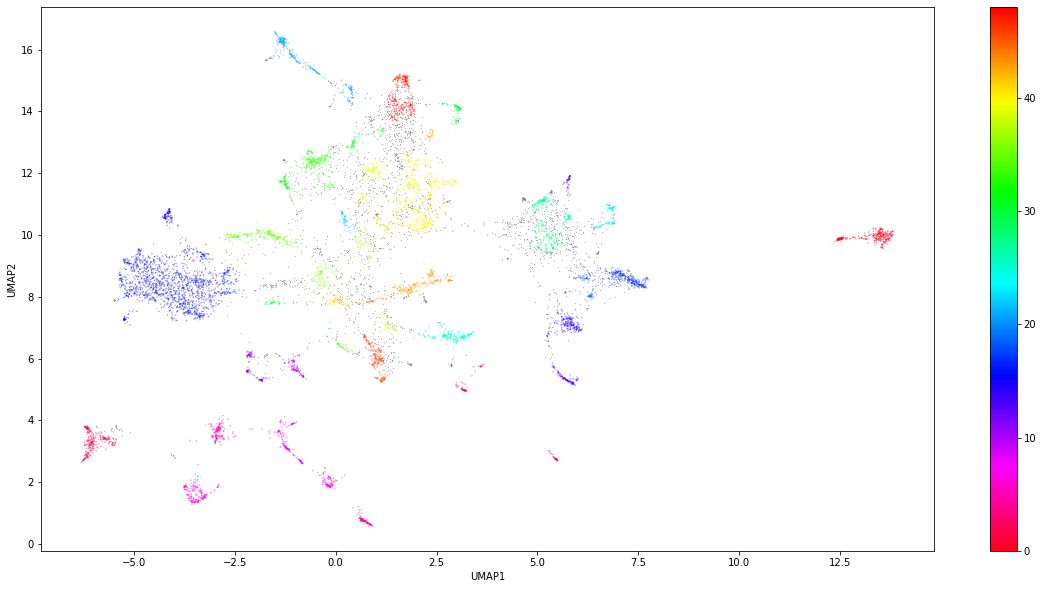

In [ ]:
# Separate outliers from cluserts
outliers = result.loc[result['labels']==-1, :]
clustered = result.loc[result['labels']!=-1, :]

import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.scatter(outliers['x'], outliers['y'], color='gray', s=0.05)
plt.scatter(clustered['x'], clustered['y'], c=clustered['labels'], cmap='hsv_r', s=0.05)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar()
plt.savefig('UMAP_Plot.png')

Each dot on the above chart represents an article and the distance between them are similarities based on UMAP dimension reduction. The colors denote the clusters determined by HBDSCAN. Outliers are denoted by grey. 


In this 2D representation, although it is difficult to tell one from another between similar topic ids, we can certainly see the different clusters separated from each other. It is interesting to see that the outliers are generally concentrated in the center. To the left we see a dark blue blog and in the center there is a yellow blob. The red-ish topics are scattered in smaller groups around the perimeter. From this diagram, I have a feeling we may be able to cluster these documents into 3-4 main topics with some more tweaking.

In [ ]:
len(outliers)/len(result)*100

22.34535563167439

~22% of the articles could not find itself fitting into any one cluster.

In [ ]:
# Save umap2d and hbdscan labels as csv
result.to_csv('UMAP2D_HBDSCAN_results.csv')

### Topic Creation

From here, we want to understand what makes one cluster different from another. To do this, Maarten came up with a variant of TF-IDF. We will treat all documents in a single cluster as a single document and apply TF-IDF. Based on the TF-IDF score we will extract the important words within a cluster.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9926 entries, 0 to 9925
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   article_id        9926 non-null   int64 
 1   title             9926 non-null   object
 2   publication_type  9807 non-null   object
 3   abstract          8892 non-null   object
 4   journal_title     9926 non-null   object
 5   citation          9926 non-null   object
 6   n_authors         9926 non-null   int64 
 7   affiliations      9926 non-null   object
 8   n_affiliations    9926 non-null   int64 
 9   n_citations       8001 non-null   object
 10  keywords          9926 non-null   object
 11  n_references      2968 non-null   object
dtypes: int64(3), object(9)
memory usage: 1.3+ MB


In [ ]:
# Prepare data

# Create dataframe with text and topic ID for each document
text_df = pd.DataFrame({'text':text_data})
text_df['Topic'] = cluster.labels_

text_df.head()

,text,Topic
0,Stem cell therapy for neurological disorders \...,-1
1,Neural stem cell therapy-Brief review \n\nPubl...,-1
2,Stem Cell Therapy in Heart Diseases - Cell Typ...,16
3,Stem Cell Therapy: A New Therapeutic Option fo...,16
4,Stem Cell Therapy for Multiple Sclerosis \n\nP...,23


In [ ]:
# Get all the documents within a topic and join each one with a new line
topic_text = text_df.groupby('Topic').agg({'text': '\n'.join}).reset_index()

We will extract the frequency of each word for each topic and divide it by the total number of words within the topic. Then, we divide the total unjoined number of documents by the total frequency of the word across all classes. 

In [ ]:
# Apply the class-based TF-IDF

from sklearn.feature_extraction.text import CountVectorizer

# Create a function to get ctf-idf and count
def ctf_idf(text, m, ngram_range=(1,1)):
  # Count the frequency of each unique word less english stop words in the text
  count = CountVectorizer(ngram_range=ngram_range,
                          stop_words='english').fit(text)
  # Get counts for each word in the text
  t = count.transform(text).toarray()
  # Get the total number of counts for each word
  w = t.sum(axis=1)
  # Get the term frequency of each count
  tf = np.divide(t.T, w)
  # Get the total number of words for each document
  sum_t = t.sum(axis=0)
  # Get the fraction of the total documents over total frequency of word
  idf = np.log(np.divide(m, sum_t)).reshape(-1,1)
  # Multiply the term frequency to idf
  tf_idf = np.multiply(tf, idf)

  return tf_idf, count

tf_idf, count = ctf_idf(topic_text['text'].values, m=len(text_data))

In [ ]:
tf_idf.shape

(46331, 50)

For 52 topics, there were 46K unique tokens. 

In [ ]:
# Look at a sample of results
res = pd.DataFrame(tf_idf)
res['vector'] = count.get_feature_names()
res = res.set_index('vector')
res.columns = sorted(text_df['Topic'].unique())
res.reset_index(inplace=True)

# Take a look at a sample
res.sample(10)

,vector,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
13047,ctg,0.000057,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.001033,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000197,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
18232,followers,0.000025,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
5367,ageing,0.000269,0.000781,0.000000,0.000000,0.0,0.000477,0.000000,0.000292,0.000000,0.000000,0.000739,0.000517,0.00000,0.000485,0.0,0.000000,0.000000,0.000196,0.000308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000141,0.0,0.000000,0.0,0.000837,0.0,0.000541,0.000208,0.000333,0.0,0.000576,0.0,0.0,0.0,0.0,0.0
26725,majallah,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000127,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
44485,valdecilla,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000040,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
0,00,0.000063,0.000205,0.000000,0.000106,0.0,0.000000,0.000453,0.000172,0.000000,0.000227,0.000000,0.000000,0.00113,0.000000,0.0,0.000162,0.000812,0.000154,0.000363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000166,0.0,0.000144,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
30947,nrlgfp,0.000000,0.000421,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
9619,canals,0.000021,0.000000,0.000000,0.000280,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
21320,homolog,0.000082,0.000107,0.000604,0.000551,0.0,0.000000,0.000000,0.000000,0.000331,0.000000,0.000605,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000054,0.000126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000346,0.0,0.000000,0.0,0.000000,0.0,0.000332,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
17716,fena,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000932,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Get the number of documents in each topic
text_df.groupby('Topic').agg('count')['text'].sort_values(ascending=False).head(10)

Topic
-1     2218
 16    1430
 40     640
 0      324
 17     298
 2      294
 33     250
 35     242
 21     225
 25     216
Name: text, dtype: int64

Above are the Top 10 topics in terms of number of documents, where -1 denotes the outliers. The outlier group has the largest number of documents in it with ~2200. The next runner up is quite large with ~1400 documents followed by ~600 documents. The rest are between 200-300 documents. 

What separates each of these topics from each other? For this we will have to check the words associated in each topic. I will extract the top 10 keywords within each topic based on the TF-IDF metric that we calculated earlier.



In [ ]:
# List of topics
topics = text_df.groupby('Topic').agg('count')['text'].index.tolist()

# Empty list to record top10words for each topic
top10words_in_topics = {}

# Loop through each topic
for t in topics:
  # Get the indices for the top 10 words
  idx = res[t].sort_values(ascending=False)[:10].index.tolist()
  # Get the top 10 words
  top10kw = res.loc[idx, 'vector'].values
  # Turn topic into string
  topic = str(t)
  # Add into dictionary
  top10words_in_topics[t] = top10kw
  
# Create dataframe from dictionary
top_words_per_topic = pd.DataFrame(top10words_in_topics)
top_words_per_topic

,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
0,chongqing,retinal,hearing,liver,disc,erectile,kidney,diabetes,urinary,crohn,ovarian,amniotic,boston,muscle,lysosomal,spinal,limb,heart,stroke,neonatal,tbi,hiv,lung,ucb,ms,als,dental,ad,pd,neural,adscs,autoimmune,leukemia,glioma,cancer,veterinary,imaging,hydrogels,chicago,bone,hscs,pluripotent,adipose,sickle,skin,fat,tendon,cartilage,lymphoma,allogeneic
1,gene,eye,ear,hepatic,pain,ed,renal,insulin,bladder,bowel,endometrial,fluid,harvard,muscular,mps,sci,cli,cardiac,ischemic,hypoxic,traumatic,infection,pulmonary,umbilical,sclerosis,amyotrophic,pulp,alzheimer,parkinson,neurodegenerative,adipose,lupus,aml,gbm,cscs,equine,tracking,hmscs,imscs,osteoporosis,hsc,embryonic,adscs,thalassemia,wound,plastic,cuff,knee,myeloma,hematopoietic
2,disorders,corneal,inner,hepatocytes,intervertebral,dysfunction,nephrology,islet,incontinence,ibd,reproductive,haecs,fetal,dystrophy,enzyme,cord,amputation,myocardial,brain,brain,brain,infections,covid,cord,multiple,lateral,oral,amyloid,dopaminergic,brain,adsc,rheumatology,myeloid,tumor,tumor,horses,mri,engineering,msc,ovx,hematopoietic,reprogramming,ascs,globin,healing,adipose,rotator,osteoarthritis,dose,hsct
3,engineering,ophthalmology,cochlear,cirrhosis,ivd,urology,aki,pancreatic,urology,fistula,infertility,amnion,ma,skeletal,ert,injury,peripheral,cardiovascular,cerebral,maastricht,injury,aids,respiratory,blood,eae,sclerosis,periodontal,app,neurons,cns,cardiology,immune,lscs,glioblastoma,breast,cats,labeled,hydrogel,stomatology,osteoporotic,tokyo,sydney,hadscs,scd,wounds,reconstructive,tendons,oa,chemotherapy,peripheral
4,hematopoietic,visual,hair,hepatocyte,neuropathic,cavernous,tubular,beta,urethral,intestinal,poi,hafs,prenatal,myogenic,storage,nerve,ischemia,infarction,neurology,hypothermia,tampa,transplant,19,chongqing,myelin,motor,dentistry,memory,dopamine,neurological,xijing,systemic,cml,tumors,csc,horse,magnetic,3d,mscs,trabecular,stanford,shanghai,mayo,hemoglobinopathies,hair,surgery,ligament,articular,autologous,blood
5,laboratory,ocular,auditory,hepatology,degeneration,penile,injury,mellitus,sphincter,gastroenterology,endometrium,ham,children,satellite,lsds,neural,arterial,cardiology,ich,encephalopathy,fl,infectious,fibrosis,cb,autoimmune,neurology,stomatology,aβ,da,neurons,osaka,rheumatic,leukemic,brain,resistance,alfort,labeling,alginate,tmscs,fracture,japan,ethical,brown,gene,dermatology,stromal,tendinopathy,joint,high,conditioning
6,key,rpe,otolaryngology,fibrosis,np,sexual,glomerular,pancreas,sui,perianal,tabriz,source,amniotic,duchenne,mucopolysaccharidosis,recovery,vascular,failure,recovery,hie,ee,taiwan,ards,orthopaedic,cns,neurodegenerative,teeth,cognitive,replacement,nervous,manitoba,sle,lsc,gliomas,tumors,companion,vivo,culture,chongqing,defect,expansion,australia,markers,hemoglobin,epidermal,grafting,healing,sports,multiple,donor
7,science,limbal,loss,gastroenterology,discs,nerve,acute,type,stress,cd,fertility,afs,utero,dystrophies,ceroid,motor,pad,ventricular,strok,perinatal,neuroinflammation,cytomegalovirus,chongqing,uc,progressive,neuron,dpscs,dementia,midbrain,disorders,ami,autologous,flt3,chapel,targeting,feline,pet,biomaterials,osteogenic,defects,ex,ipscs,differentiation,erythroid,cutaneous,aesthetic,injuries,orthopaedic,hodgkin,hematology
8,shanghai,retina,vocal,livers,pulposus,intracavernous,rats,t1dm,muscle,fistulas,reproduction,characteristics,trascet,dmd,substrate,injured,critical,myocardium,neural,fgr,florida,virus,airway,huc,remyelination,riluzole,tooth,brain,fetal,neuroscience,infarction,immunosuppressive,100071,hill,cancers,animal,nanoparticles,scaffolds,laboratory,osteogenic,renewal,genome,proliferation,hematopoietic,follicle,fraction,sports,chondral,asct,graft
9,expression,vision,sensorineural,tokyo,nucleus,eswt,ckd,glucose,pelvic,colitis,iran,af,transamniotic,neuromuscular,replacement,functional,revascularization,cardiom

With this, we can see some sensible topics emerging. Topic 0 - eyes, 1 - ears, 2 - liver, 3 - spine, 4 - penile, 5 - kidney, 6 - pancreas. It is also really nice to see that the disease type matches the organ. We can see in topic 8 crohn's and ibd with intestinal, topic 9 - endometrial with ovarian, stroke with brain, copd with lung. There are also topics with dieseases relating to symptoms like topic 26 alzheimer and memory as well as a topic related to imaging (topic 35). 

It is also interesting to see that there certain locations that crop up in the top 10 words. Topic 40 - australia and shanghai, Topic 39 - Japan, Tokyo, Stanford, Topic 12 - Boston. These places may be hot spots for specific research areas within stem cell therapies. 

In [ ]:
# Save transposed and aggregated list into a dataframe
top10words_per_topic = pd.DataFrame({'top10words':top_words_per_topic.T.agg(' '.join, axis=1)}).reset_index().rename(columns={'index':'Topic'})

In [ ]:
# Look at the top10words for each topic
top10words_per_topic

,Topic,top10words
0,-1,chongqing gene disorders engineering hematopoi...
1,0,retinal eye corneal ophthalmology visual ocula...
2,1,hearing ear inner cochlear hair auditory otola...
3,2,liver hepatic hepatocytes cirrhosis hepatocyte...
4,3,disc pain intervertebral ivd neuropathic degen...
5,4,erectile ed dysfunction urology cavernous peni...
6,5,kidney renal nephrology aki tubular injury glo...
7,6,diabetes insulin islet pancreatic beta mellitu...
8,7,urinary bladder incontinence urology urethral ...
9,8,crohn bowel ibd fistula intestinal gastroenter...


In [ ]:
# Put everything together into a dataframe
manualBERTopic_results = text_df.join(top10words_per_topic.set_index('Topic'), on='Topic')
idx = manualBERTopic_results[manualBERTopic_results['Topic']==-1].index
manualBERTopic_results.loc[idx, 'top10words'] = 'outlier'
manualBERTopic_results

,text,Topic,top10words
0,Stem cell therapy for neurological disorders \...,-1,outlier
1,Neural stem cell therapy-Brief review \n\nPubl...,-1,outlier
2,Stem Cell Therapy in Heart Diseases - Cell Typ...,16,heart cardiac myocardial cardiovascular infarc...
3,Stem Cell Therapy: A New Therapeutic Option fo...,16,heart cardiac myocardial cardiovascular infarc...
4,Stem Cell Therapy for Multiple Sclerosis \n\nP...,23,ms sclerosis multiple eae myelin autoimmune cn...
...,...,...,...
9921,Differentiation versus maturation of neoplasti...,39,hscs hsc hematopoietic tokyo stanford japan ex...
9922,Role of autologous stem cell transplantation i...,48,allogeneic hematopoietic hsct peripheral blood...
9923,Mitoxantrone/ifosfamide/etoposide salvage regi...,47,lymphoma myeloma dose chemotherapy autologous ...
9924,Therapeutic potential of mesenchymal stem cell...,6,diabetes insulin islet pancreatic beta mellitu...


In [ ]:
# Save results into csv
manualBERTopic_results.to_csv('manualBERTopic_result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### BERTopic

Now I would like to use [BERTopic](https://github.com/MaartenGr/BERTopic) to perform the same analysis in just a few lines. As well, I would like to leverage BERTopic's visualizations to create an interactive plot with the resulting topics. 

In [ ]:
from bertopic import BERTopic

In [ ]:
# Define embedding_model
sentence_model = SentenceTransformer('allenai-specter')

# Set up umap
umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=5,
                            metric='cosine', 
                            min_dist=0.1)

# set up hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=30, # Cluster size can be adjusted to control n_clusters
                          metric='euclidean',
                          cluster_selection_method='eom')

topic_model = BERTopic(embedding_model=sentence_model,
                       umap_model=umap_embeddings,
                       hdbscan_model=cluster,
                       verbose=True)

In [ ]:
# Fit the model to text_data
topics, _ = topic_model.fit_transform(text_data)

2021-07-17 05:56:26,293 - BERTopic - Transformed documents to Embeddings


2021-07-17 05:56:54,494 - BERTopic - Reduced dimensionality with UMAP
2021-07-17 05:56:54,831 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [ ]:
# Look at topic_info
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,2499,-1_university_medicine_medical_research
1,0,1343,0_cardiac_heart_myocardial_cardiovascular
2,1,326,1_retinal_eye_corneal_ophthalmology
3,2,305,2_therapies_research_review_medicine
4,3,296,3_stroke_ischemic_brain_neurology
5,4,294,4_liver_hepatic_hepatocytes_cirrhosis
6,5,256,5_wound_skin_healing_wounds
7,6,247,6_cancer_tumor_resistance_tumors
8,7,246,7_imaging_vivo_magnetic_labeled
9,8,234,8_lung_pulmonary_respiratory_fibrosis


Although the numberings are slightly different, I see that the topics created by BERTopic are quite similar to the previous results giving me confidence about the stability of this model. For example, we see a topic for alheimers, leukemia, ovarian, intestinal, heart, and eyes.

In [ ]:
# Visualize the model
vis = topic_model.visualize_topics()
vis

BERTopic also allows you to visualize the topics very simply in a similar fashion to pyLDAvis. Each cluster is sized according to the number of topics within it and the similarity between them denoted by the distance from one another. We can also hover around the clusters to see the topic number and the key words associated with them as well as zoom in on a certain part of the plot to get a close up look at clusters of clusters. 

I am happy to see that there are some groupings of similar topics like the engineering/imaging group, cancer group, and brain group. I see that brain is scattered across the diagram, so is heart. These two organs seems to be quite a prominent research area in this field. 

In [ ]:
# Save visual as pkl
joblib.dump(vis, 'IntertopicDistanceMap_BERTopic.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Get timestamps
timestamps = pub_years.astype('datetime64')

In [ ]:
# Get the topics over time
topics_over_time = topic_model.topics_over_time(text_data, topics, timestamps)

46it [01:21,  1.76s/it]


In [ ]:
# Visualize topic evolution over time
timecourse_vis = topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20)
timecourse_vis

BERTopic also allows for the visualization of how each topic evolves over time. The word extraction for each topic is performed at each time step so we can see how a specific topic evolves over time. For example in Topic 8, we see that 'covid19' emerges as a key word in 2021. Many researchers in the field have pivoted to support Covid19 research since 2020 and are now publishing their results. In topic 3, 'clinical' props up more often in recent years, perhaps there are some treatments in that field with results from clinical trials. 

In [ ]:
# Save timecourse visual as pkl
joblib.dump(timecourse_vis, 'timecourse_vis_BERTopic.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Download all files
from google.colab import files
files.download("allenai-specter_embeddings.pkl") 
files.download('UMAP_Plot.png') 
files.download('manualBERTopic_result.csv')
files.download('IntertopicDistanceMap_BERTopic.pkl')
files.download('timecourse_vis_BERTopic.pkl')
files.download('UMAP2D_HBDSCAN_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Summary

Inspired by Maarten Grootendorst's [work](https://maartengr.github.io/BERTopic/index.html), I used BERT to cluster the 9000+ search query results from PubMed about 'stem cell therapies'. For this task, I used Google Colab as it allowed me to use the GPU for model fitting, which was reduced to ~8 minutes from 2 hours on my local computer. I leveraged [allenai-specter](https://huggingface.co/allenai/specter), a sentence transformer pre-trained on 146K Semantic Scholar query results that learned document relatedness based on citation graphs. The dimension of the resulting embeddings were reduced using UMAP and clustered by HBDSCAN into topics. Then the entire text data from each topic was vectorized to extract the top 10 most important words within the topic. The model resulted in ~50 various topics that were sensible. Topics ranged from different organ types like heart, kidney, and lungs, to disease types like alzheimers and cancer, and interestingly methods like imaging. I performed the same task in a few lines using BERTopic, Maarten Grootendorst's specialized package for Topic Modeling with BERT. 

#### Drawbacks and Future Steps

Some drawbacks of this method is the large population of outliers. I would like to extract these and try to fit BERTopic to see if there can be any clusterings just among them. If there are sensible topics there, I want to adjust some of the parameters in the UMAP and HBDSCAN to optimize the clustering. For the dynamic topic modeling, BERTopic allowed for the visualization of the evolution of each topic. I would like to see the evolution of the topics for the entire field. For this I would have to fit the model for each time step that I am interested in. Finally, to understand the field as a whole, I wonder if it would suffice to perform the cTF-IDF alone for all of the documents.

Furthermore, BERTopic as a whole is quite compuationally intensive. I was able to leverage Google Colab's GPU and reduce the time from 2 hours to 8 minutes for fitting the sentence transformer. However, this may take longer if we start to add more publications into the dataset. 